In [1]:
import os
import sys
os.chdir("../AnalysisCode")
from PowerIteration_Functions import *
os.chdir("../data")
from CB_02704 import *
np.random.seed(42)

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter
import pandas as pd
import seaborn as sns
from sklearn.metrics import adjusted_rand_score


In [ ]:
CEU = read_geno_pop_chr('CEU',2) #northern European, USA
YRI = read_geno_pop_chr('YRI',2) ##Yoruba, Nigeria
CHB = read_geno_pop_chr('CHB',2) #Chinese, China
JPT = read_geno_pop_chr('JPT',2) #Japanese, Japan
CHD = read_geno_pop_chr('CHD',2) #Chinese, Denver
CHD_all = read_geno_pop('CHD') #Chinese, Denver - all chromosomes
CHB_all = read_geno_pop('CHB') #Chinese, China - all chromosomes

def GetCombinedGenoCEU_YRI_CHB(CEU, YRI, CHB, n):
    # Slice the first n columns of each array
    CEU_subset = CEU[:, :n]
    YRI_subset = YRI[:, :n]
    CHB_subset = CHB[:, :n]

    # Horizontally stack the sliced arrays
    combined = np.ma.hstack([CEU_subset, YRI_subset, CHB_subset])
    return combined

def GetCombinedGenoCHD_CHB_JPT(CHD, CHB, JPT, n):
    # Slice the first n columns of each array
    CHD_subset = CHD[:, :n]
    CHB_subset = CHB[:, :n]
    JPT_subset = JPT[:, :n]

    # Horizontally stack the sliced arrays
    combined = np.ma.hstack([CHD_subset, CHB_subset, JPT_subset])
    return combined

def GetCombinedGenoCHD_CHB(CHD, CHB, n):
    # Slice the first n columns of each array
    CHD_subset = CHD[:, :n]
    CHB_subset = CHB[:, :n]

    # Horizontally stack the sliced arrays
    combined = np.ma.hstack([CHD_subset, CHB_subset])
    return combined






def cluster_top_pcs(X, n_clusters, n_pcs_to_cluster, true_labels=None):
    # X: numpy array of shape (n_samples, n_pcs), data matrix with PCs as columns.
    X_clustering = X[:, :n_pcs_to_cluster]

    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X_clustering) # Get cluster assignments
    
    # If true_labels are provided, print the correspondence within each cluster
    # if true_labels is not None:
        # true_labels = np.array(true_labels)
        # print("Label distribution within each cluster:")
        # for i in range(n_clusters):
            # idx = np.where(cluster_labels == i)[0]
            # labels_in_cluster = true_labels[idx]
            # counts = Counter(labels_in_cluster)
            # print(f"\nCluster {i}:")
            # for label, count in counts.items():
                # print(f"  Label {label}: {count}")

                
    # Reduce data to 2D using PCA for visualization
    pca = PCA(n_components=2) # Can I do this? Might not be a good idea
    X_2d = pca.fit_transform(X_clustering)
    
    # Convert to DataFrame for Seaborn plotting
    df = pd.DataFrame(X_2d, columns=['PC1', 'PC2'])
    df['Cluster'] = cluster_labels.astype(str)  # Convert cluster labels to strings for color mapping
    
    # # Plot using Seaborn
    # plt.figure(figsize=(8, 6))
    # sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette='husl', s=70, edgecolor='k', alpha=0.7)
    # plt.title(f'Clusters of Data Points using Top {n_pcs_to_cluster} PCs')
    # plt.xlabel('Principal Component 1')
    # plt.ylabel('Principal Component 2')
    # plt.legend(title='Cluster')
    # plt.grid(True)
    # plt.show()
    
    return cluster_labels




def get_Kmeans_of_PC(n, top10PCs, label_count):
    # Initialize lists to store the results
    results = {
        'n_pcs': [],
        'adjusted_rand_index': []
    }

    # Run clustering for different numbers of PCs and collect metrics
    for pc in range(2, 11):
        # print(f"\nClustering using top {pc} PCs:")
        # Perform clustering and plot
        cluster_labels = cluster_top_pcs(top10PCs, n_clusters=n, n_pcs_to_cluster=pc, true_labels=[0]*label_count + 
                                         [1]*label_count + [2]*label_count)
        
        # Calculate Adjusted Rand Index
        if n == 3:
            ari = adjusted_rand_score([0]*label_count + [1]*label_count + [2]*label_count, cluster_labels)
        elif n == 2:
            ari = adjusted_rand_score([0]*label_count + [1]*label_count, cluster_labels)
            
        # print(f"Adjusted Rand Index for {pc} PCs: {ari:.4f}")
        
        # Store results
        results['n_pcs'].append(pc)
        results['adjusted_rand_index'].append(ari)

    return results



In [4]:
def cluster_top_pcs(X, n_clusters, n_pcs_to_cluster, true_labels=None):
    # Ensure X is a NumPy array
    X = np.array(X)
    
    # Slice the first n_pcs_to_cluster principal components
    X_clustering = X[:, :n_pcs_to_cluster]
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X_clustering)  # Get cluster assignments
    
    # Reduce data to 2D using PCA for visualization (if necessary)
    pca = PCA(n_components=2)  # Optional: May not be ideal for all clustering tasks
    X_2d = pca.fit_transform(X_clustering)
    
    # Convert to DataFrame for Seaborn plotting (if plotting is used)
    df = pd.DataFrame(X_2d, columns=['PC1', 'PC2'])
    df['Cluster'] = cluster_labels.astype(str)  # Convert cluster labels to strings for color mapping
    
    return cluster_labels

def get_Kmeans_of_PC(n, top10PCs, label_count):
    # Initialize lists to store the results
    results = {
        'n_pcs': [],
        'adjusted_rand_index': []
    }

    # Run clustering for different numbers of PCs and collect metrics
    for pc in range(2, 11):
        # Perform clustering
        cluster_labels = cluster_top_pcs(top10PCs, n_clusters=n, n_pcs_to_cluster=pc)
        
        # Generate true labels based on number of samples
        num_samples = top10PCs.shape[0]
        true_labels = (
            [0] * (num_samples // n) + 
            [1] * (num_samples // n) + 
            [2] * (num_samples - 2 * (num_samples // n))
        )

        # Calculate Adjusted Rand Index
        ari = adjusted_rand_score(true_labels, cluster_labels)

        # Store results
        results['n_pcs'].append(pc)
        results['adjusted_rand_index'].append(ari)

    return results


# Convert results to a DataFrame for easy manipulation
def plot_results(results, title):

    results_df = pd.DataFrame(results)

    # Plot Adjusted Rand Index vs. Number of PCs
    plt.figure(figsize=(5, 3))
    sns.lineplot(data=results_df, x='n_pcs', y='adjusted_rand_index', marker='o', color='black')
    plt.title("Clustering Performance for "+title)
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Adjusted Rand Index")
    plt.grid(True)
    plt.show()

    results_df["adjusted_rand_index"].values



Power iteration: converged at iter=42
Power iteration: converged at iter=1
Power iteration: converged at iter=413
Power iteration: converged at iter=128
Power iteration: converged at iter=785
Power iteration: converged at iter=1
Power iteration: converged at iter=1669
Power iteration: converged at iter=61
Power iteration: converged at iter=111
Power iteration: converged at iter=4858
Power iteration: converged at iter=23
Power iteration: converged at iter=1
Power iteration: converged at iter=681
Power iteration: converged at iter=1247
Power iteration: converged at iter=448
Power iteration: converged at iter=2
Power iteration: converged at iter=1545
Power iteration: converged at iter=1
Power iteration: converged at iter=557
Power iteration: converged at iter=1120
Power iteration: converged at iter=27
Power iteration: converged at iter=1
Power iteration: converged at iter=887
Power iteration: converged at iter=1
Power iteration: converged at iter=382
Power iteration: converged at iter=561

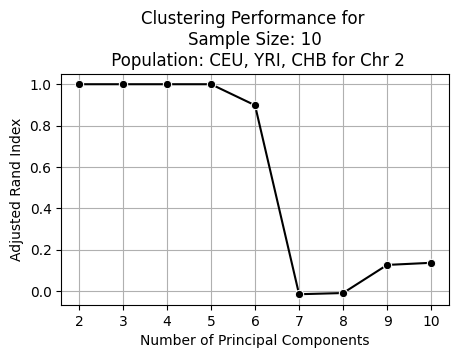

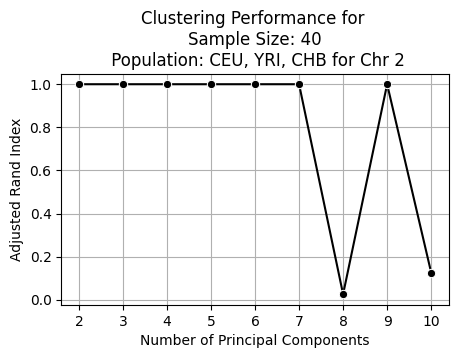

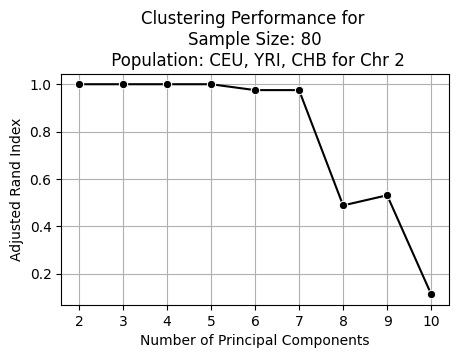

In [5]:

'''Get the top 10 PCs and run KMeans clustering for 3 clusters for different sample sizes'''

clusters = 3
label_count = 10
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCEU_YRI_CHB(CEU, YRI, CHB, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_10 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

label_count = 40
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCEU_YRI_CHB(CEU, YRI, CHB, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_40 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

label_count = 80
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCEU_YRI_CHB(CEU, YRI, CHB, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_80 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

plot_results(results_10, "\nSample Size: 10\n Population: CEU, YRI, CHB for Chr 2")
plot_results(results_40, "\nSample Size: 40\n Population: CEU, YRI, CHB for Chr 2")
plot_results(results_80, "\nSample Size: 80\n Population: CEU, YRI, CHB for Chr 2")



Power iteration: converged at iter=363
Power iteration: converged at iter=2
Power iteration: converged at iter=281
Power iteration: converged at iter=4107
Power iteration: converged at iter=1
Power iteration: converged at iter=947
Power iteration: converged at iter=2
Power iteration: converged at iter=2398
Power iteration: converged at iter=1
Power iteration: converged at iter=868
Power iteration: converged at iter=89
Power iteration: converged at iter=55
Power iteration: converged at iter=982
Power iteration: converged at iter=55
Power iteration: converged at iter=13
Power iteration: converged at iter=433
Power iteration: converged at iter=1776
Power iteration: converged at iter=1
Power iteration: converged at iter=1813
Power iteration: converged at iter=2
Power iteration: converged at iter=33
Power iteration: converged at iter=354
Power iteration: converged at iter=344
Power iteration: converged at iter=2
Power iteration: converged at iter=899
Power iteration: converged at iter=2
Pow

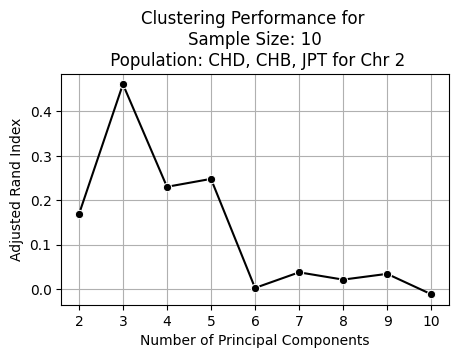

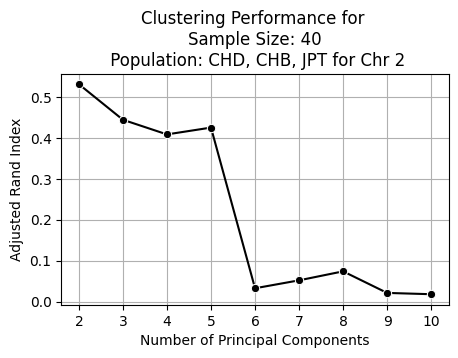

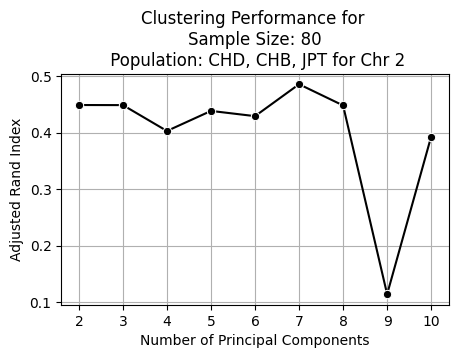

In [6]:

'''Get the top 10 PCs and run KMeans clustering for 3 clusters for different sample sizes and pops: CHD, CHB, JPT'''

clusters = 3
label_count = 10
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB_JPT(CHD, CHB, JPT, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_10 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

label_count = 40
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB_JPT(CHD, CHB, JPT, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_40 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

label_count = 80
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB_JPT(CHD, CHB, JPT, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_80 = get_Kmeans_of_PC(clusters, top10PCs, label_count)


plot_results(results_10, "\nSample Size: 10\n Population: CHD, CHB, JPT for Chr 2")
plot_results(results_40, "\nSample Size: 40\n Population: CHD, CHB, JPT for Chr 2")
plot_results(results_80, "\nSample Size: 80\n Population: CHD, CHB, JPT for Chr 2")


Power iteration: converged at iter=616
Power iteration: converged at iter=413
Power iteration: converged at iter=2
Power iteration: converged at iter=239
Power iteration: converged at iter=1153
Power iteration: converged at iter=1
Power iteration: converged at iter=637
Power iteration: converged at iter=388
Power iteration: converged at iter=686
Power iteration: converged at iter=1
(10, 20)
Power iteration: converged at iter=123
Power iteration: converged at iter=761
Power iteration: converged at iter=40
Power iteration: converged at iter=152
Power iteration: converged at iter=371
Power iteration: converged at iter=7571
Power iteration: converged at iter=2
Power iteration: converged at iter=823
Power iteration: converged at iter=264
Power iteration: converged at iter=609
Power iteration: converged at iter=225
Power iteration: converged at iter=189
Power iteration: converged at iter=981
Power iteration: converged at iter=152
Power iteration: converged at iter=376
Power iteration: conver

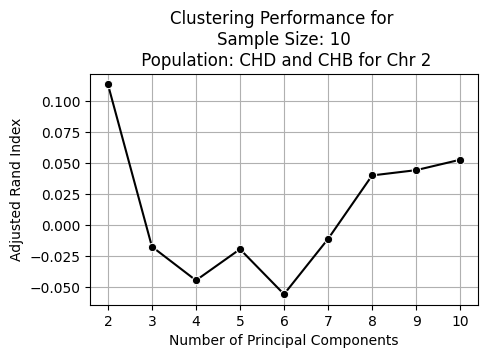

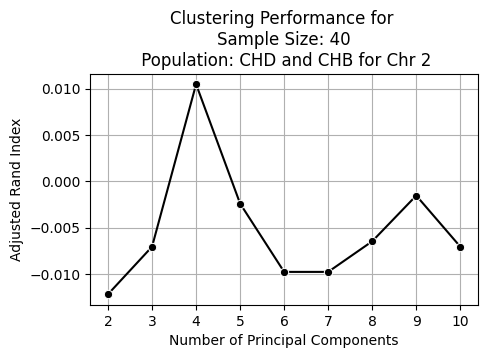

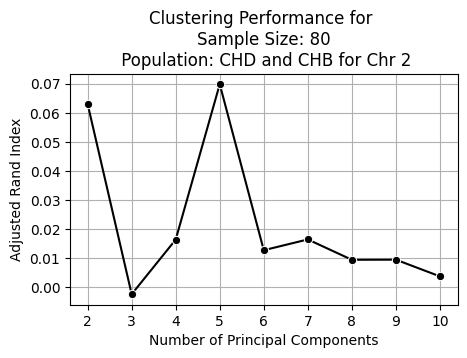

In [7]:

'''Get the top 10 PCs and run KMeans clustering for 3 clusters for different sample sizes and pops: CHD, CHB for Chr 2'''

clusters = 2
label_count = 10
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB(CHD, CHB, label_count))
print(np.array(top10PCs).shape)
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_10 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

label_count = 40
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB(CHD, CHB, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_40 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

label_count = 80
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB(CHD, CHB, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_80 = get_Kmeans_of_PC(clusters, top10PCs, label_count)


plot_results(results_10, "\nSample Size: 10\n Population: CHD and CHB for Chr 2")
plot_results(results_40, "\nSample Size: 40\n Population: CHD and CHB for Chr 2")
plot_results(results_80, "\nSample Size: 80\n Population: CHD and CHB for Chr 2")


Power iteration: converged at iter=1306
Power iteration: converged at iter=1
Power iteration: converged at iter=1606
Power iteration: converged at iter=554
Power iteration: converged at iter=1645
Power iteration: converged at iter=505
Power iteration: converged at iter=2
Power iteration: converged at iter=6452
Power iteration: converged at iter=2
Power iteration: converged at iter=28842
Power iteration: converged at iter=80
Power iteration: converged at iter=134
Power iteration: converged at iter=5
Power iteration: converged at iter=2085
Power iteration: converged at iter=1296
Power iteration: converged at iter=1
Power iteration: converged at iter=2480
Power iteration: converged at iter=4286
Power iteration: converged at iter=1
Power iteration: converged at iter=627
Power iteration: converged at iter=178
Power iteration: converged at iter=1
Power iteration: converged at iter=103
Power iteration: converged at iter=1504
Power iteration: converged at iter=18629
Power iteration: converged 

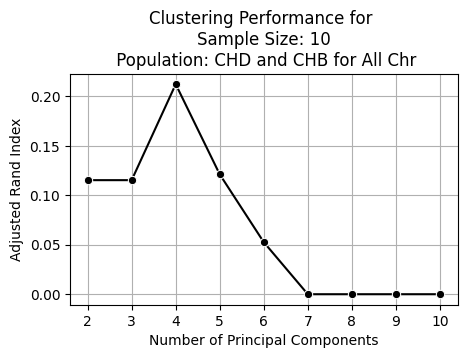

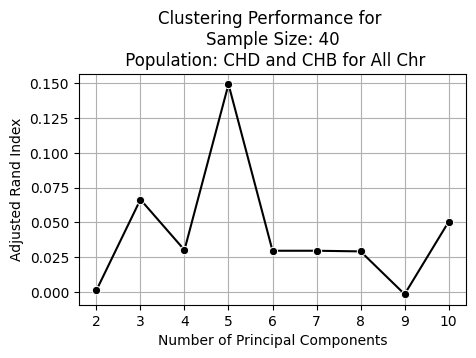

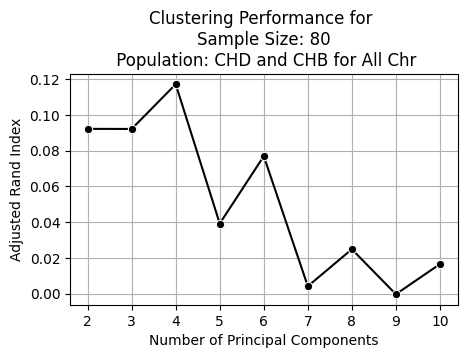

In [8]:

'''Get the top 10 PCs and run KMeans clustering for 3 clusters for different sample sizes and pops: CHD, CHB for All Chr'''

clusters = 2
label_count = 10
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB(CHD_all, CHB_all, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_10 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

label_count = 40
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB(CHD_all, CHB_all, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_40 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

label_count = 80
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(GetCombinedGenoCHD_CHB(CHD_all, CHB_all, label_count))
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 10)
results_80 = get_Kmeans_of_PC(clusters, top10PCs, label_count)


plot_results(results_10, "\nSample Size: 10\n Population: CHD and CHB for All Chr")
plot_results(results_40, "\nSample Size: 40\n Population: CHD and CHB for All Chr")
plot_results(results_80, "\nSample Size: 80\n Population: CHD and CHB for All Chr")


In [9]:
pop_labels = ['CHB','JPT','YRI','CEU']

#This may take a while
genos = []
for pop in pop_labels:
    print('reading', pop)
    genos.append(read_geno_pop(pop))


reading CHB
reading JPT
reading YRI
reading CEU


In [10]:
def GetCombinedGeno(genos, n): #n is the number of individuals to be included
    subsets = []
    # Slice the first n columns of each array
    for geno in genos:
        subsets.append(geno[:,:n])

    # Horizontally stack the sliced arrays
    combined = np.ma.hstack(subsets)
    return combined

comb = GetCombinedGeno(genos, 80)

CHB_JPT = comb[:, :160]
CHB_JPT_YRI = comb[:, :240]
CHB_JPT_YRI_CEU = comb

Power iteration: converged at iter=30
Power iteration: converged at iter=644
Power iteration: converged at iter=287
Power iteration: converged at iter=3782
Power iteration: converged at iter=2
Power iteration: converged at iter=3511
Power iteration: converged at iter=2655
Power iteration: converged at iter=2
Power iteration: converged at iter=2902
Power iteration: converged at iter=1937
Power iteration: converged at iter=6
Power iteration: converged at iter=21
Power iteration: converged at iter=859
Power iteration: converged at iter=1
Power iteration: converged at iter=399
Power iteration: converged at iter=1645
Power iteration: converged at iter=1859
Power iteration: converged at iter=2
Power iteration: converged at iter=158
Power iteration: converged at iter=3197
Power iteration: converged at iter=26
Power iteration: converged at iter=1
Power iteration: converged at iter=42
Power iteration: converged at iter=31
Power iteration: converged at iter=1289
Power iteration: converged at ite

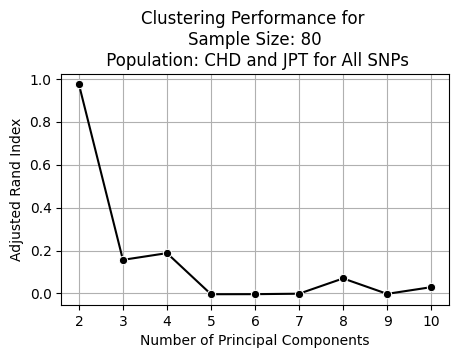

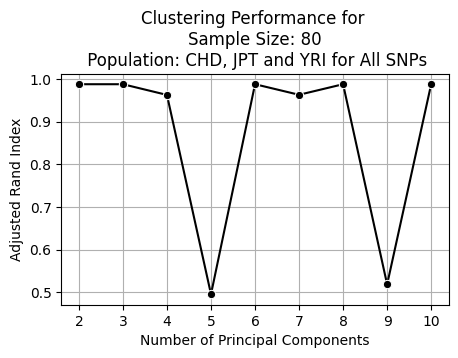

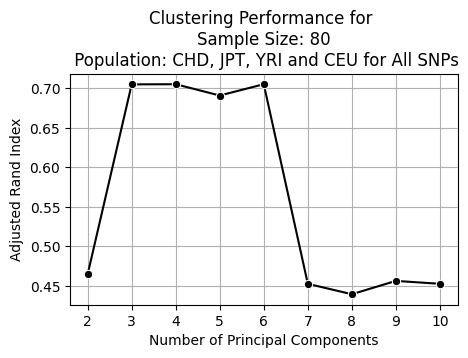

In [12]:

'''Get the top 10 PCs and run KMeans clustering for 3 clusters for different sample sizes and pops: CHD, CHB for All Chr'''

clusters = 2
label_count = 80
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(CHB_JPT)
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 80)
results_10 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

clusters = 3
label_count = 80
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(CHB_JPT_YRI)
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 80)
results_40 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

clusters = 4
label_count = 80
# Run your power iteration function to get top 10 PCs
top10PCs = RunPowerIteration10PCs(CHB_JPT_YRI_CEU)
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 80)
results_80 = get_Kmeans_of_PC(clusters, top10PCs, label_count)


plot_results(results_10, "\nSample Size: 80\n Population: CHD and JPT for All SNPs")
plot_results(results_40, "\nSample Size: 80\n Population: CHD, JPT and YRI for All SNPs")
plot_results(results_80, "\nSample Size: 80\n Population: CHD, JPT, YRI and CEU for All SNPs")

In [18]:
df = pd.read_csv('../AnalysisCode/pop_info.csv')
df

pop_labels = df['label'].tolist()
pop_labels[7] = 'MXL' #for some reason MEX is labeled as MXL in the csv file
pop_labels

#This may take a while (8ish minutes)
genos = []
for pop in pop_labels:
    print('reading', pop)
    genos.append(read_geno_pop(pop))


reading ASW
reading CEU
reading CHB
reading CHD
reading GIH
reading JPT
reading LWK
reading MXL
reading MKK
reading TSI
reading YRI


In [19]:
def GetCombinedGeno(genos, n): #n is the number of individuals to be included
    subsets = []
    # Slice the first n columns of each array
    for geno in genos:
        subsets.append(geno[:,:n])

    # Horizontally stack the sliced arrays
    combined = np.ma.hstack(subsets)
    return combined

comb = GetCombinedGeno(genos, 40)

def GetPCsWithVaryingSNPs(genos,n,m):
    if m > 699093:
        print('m is too large')
        return
    np.random.seed(42)
    combined = GetCombinedGeno(genos, n)
    combined = combined[:m]
    top10PCs = RunPowerIteration10PCs(combined)
    return top10PCs

Power iteration: converged at iter=22
Power iteration: converged at iter=1
Power iteration: converged at iter=89
Power iteration: converged at iter=47
Power iteration: converged at iter=1
Power iteration: converged at iter=82
Power iteration: converged at iter=49
Power iteration: converged at iter=301
Power iteration: converged at iter=709
Power iteration: converged at iter=1
Power iteration: converged at iter=19
Power iteration: converged at iter=1
Power iteration: converged at iter=107
Power iteration: converged at iter=1
Power iteration: converged at iter=34
Power iteration: converged at iter=431
Power iteration: converged at iter=1
Power iteration: converged at iter=3959
Power iteration: converged at iter=1
Power iteration: converged at iter=253
Power iteration: converged at iter=18
Power iteration: converged at iter=1
Power iteration: converged at iter=94
Power iteration: converged at iter=1
Power iteration: converged at iter=41
Power iteration: converged at iter=595
Power iterati

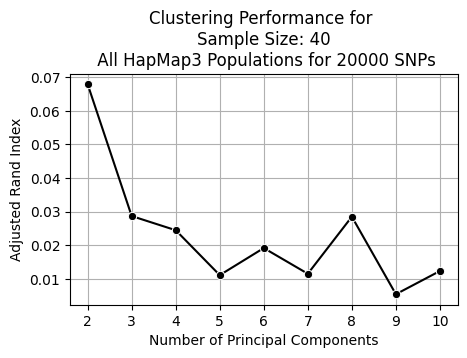

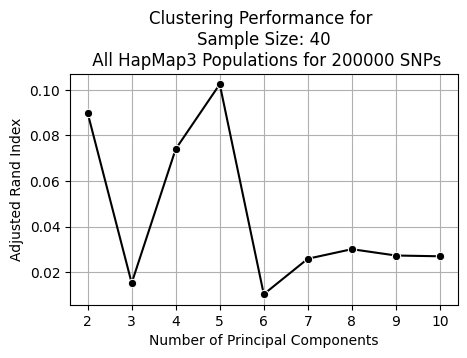

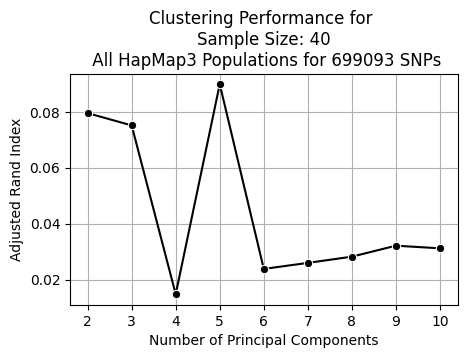

In [22]:

'''Get the top 10 PCs and run KMeans clustering for 3 clusters for different sample sizes and pops: CHD, CHB for All Chr'''

clusters = 11
label_count = 40
# Run your power iteration function to get top 10 PCs
top10PCs = GetPCsWithVaryingSNPs(genos, label_count, 20000)
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 80)
results_10 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

clusters = 11
label_count = 40
# Run your power iteration function to get top 10 PCs
top10PCs = GetPCsWithVaryingSNPs(genos, label_count, 200000)
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 80)
results_40 = get_Kmeans_of_PC(clusters, top10PCs, label_count)

clusters = 11
label_count = 40
# Run your power iteration function to get top 10 PCs
top10PCs = GetPCsWithVaryingSNPs(genos, label_count, 699093)
# Convert the list of PCs to a NumPy array and transpose
top10PCs = np.array(top10PCs).T  # Shape should now be (n_samples, 80)
results_80 = get_Kmeans_of_PC(clusters, top10PCs, label_count)


plot_results(results_10, "\nSample Size: 40\n All HapMap3 Populations for 20000 SNPs")
plot_results(results_40, "\nSample Size: 40\n All HapMap3 Populations for 200000 SNPs")
plot_results(results_80, "\nSample Size: 40\n All HapMap3 Populations for 699093 SNPs")